## Classification de présidents 

In [75]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import codecs
import re
import string

import unicodedata
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
import spacy

from wordcloud import WordCloud

from nltk.corpus import stopwords


from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import f1_score, accuracy_score, roc_auc_score

import warnings
warnings.filterwarnings("ignore")

In [3]:
STOP_WORDS = stopwords.words("french")
nlp = spacy.load("fr_core_news_lg")

In [4]:
# Chargement des données:
def load_pres(fname):
    alltxts = []
    alllabs = []
    s=codecs.open(fname, 'r','utf-8') # pour régler le codage
    while True:
        txt = s.readline()
        if(len(txt))<5:
            break
        #
        lab = re.sub(r"<[0-9]*:[0-9]*:(.)>.*","\\1",txt)
        txt = re.sub(r"<[0-9]*:[0-9]*:.>(.*)","\\1",txt)
        if lab.count('M') >0:
            alllabs.append(-1)
        else: 
            alllabs.append(1)
        alltxts.append(txt)
    return np.array(alltxts), np.array(alllabs)


In [5]:
fname = "./datasets/AFDpresidentutf8/corpus.tache1.learn.utf8"
alltxts, alllabs = load_pres(fname)

In [6]:
print(len(alltxts),len(alllabs))
print(alltxts[0])
print(alllabs[0])
print(alltxts[-1])
print(alllabs[-1])


57413 57413
 Quand je dis chers amis, il ne s'agit pas là d'une formule diplomatique, mais de l'expression de ce que je ressens.

1
 Je compte sur vous.

1


In [7]:
np.unique(alllabs) # nos labels

array([-1,  1])

# A) Transformation paramétrique du texte (pre-traitements)

Vous devez tester, par exemple, les cas suivants:
- transformation en minuscule ou pas
- suppression de la ponctuation
- transformation des mots entièrement en majuscule en marqueurs spécifiques
- suppression des chiffres ou pas
- conservation d'une partie du texte seulement (seulement la première ligne = titre, seulement la dernière ligne = résumé, ...)
- stemming
- ...


Vérifier systématiquement sur un exemple ou deux le bon fonctionnement des méthodes sur deux documents (au moins un de chaque classe).

In [8]:
index = np.arange(len(alltxts))
Xtrain, Xtest, ytrain, ytest = train_test_split(alltxts, alllabs, stratify=alllabs)

In [9]:
def lemmatize_text(text):
    tokens = word_tokenize(text)
    docs = list(nlp.pipe(tokens, disable=["parser", "ner"]))
    tokens_lem = [doc[0].lemma_ for doc in docs]
    text = ' '.join(tokens_lem)
    return text

def lemmatize_data(data):
    lemmatize_text_vec = np.vectorize(lemmatize_text)
    data_lem = lemmatize_text_vec(data)
    return data_lem

if "Xtrain_lem" not in globals():
    Xtrain_lem = lemmatize_data(Xtrain)

In [10]:
def get_strategie(text, X):
    
    punc = string.punctuation  
    punc += '\n\r\t'
    text = text.translate(str.maketrans(punc, ' ' * len(punc)))
    
    text = unicodedata.normalize('NFD', text).encode('ascii', 'ignore').decode("utf-8")
    text = re.sub('(www|http)[\w\.-_]+\.(fr|com|org)', 'URL', text)

    if X["ToLower"] :
        text = text.lower()
        
    if X["DeleteNumbers"]:
        text = re.sub('[0-9]+', '', text)
    
    return text

def fit(X, count_vec=False):
    preprocess  = None
    stopwords   = None
    ngram_range = (1, 1)
    use_idf     = True
    min_df = 1
    max_df = 1.0
    max_features = None
    binary = False
    data = Xtrain

    if X is not None:
        preprocess = lambda text : get_strategie(text, X)
        
        if "stopwords" in X:
            stopwords  = X["stopwords"]
        if "ngram_range" in X:
            ngram_range = X["ngram_range"]
        if "use_idf" in X:
            use_idf = X["use_idf"]
        if "min_df" in X:
            min_df = X["min_df"]
        if "max_df" in X:
            max_df = X["max_df"]
        if "max_features" in X:
            max_features = X["max_features"]
        if "binary" in X:
            binary = X["binary"]
        if "lemmatized" in X and X["lemmatized"]:
            data = Xtrain_lem

    if count_vec:   
        vectorizer = CountVectorizer(preprocessor=preprocess, stop_words=stopwords)
        return vectorizer.fit_transform(data), vectorizer
    
    vectorizer = TfidfVectorizer(preprocessor=preprocess, stop_words=stopwords, ngram_range=ngram_range, use_idf=use_idf, 
                                 min_df=min_df, max_df=max_df, max_features=max_features, binary=binary)
    
    return vectorizer.fit_transform(data), vectorizer

In [11]:
X1 = {
        "name":"Lower | Not Number | Stop Words",
        "ToLower": True,
        "DeleteNumbers": True,
        "stopwords": STOP_WORDS,
        "lemmatized": True,
      }

In [12]:
strats = [X1]

# B) Extraction du vocabulaire (BoW)
- **Exploration préliminaire des jeux de données**
    



In [13]:
X_base, vectorizer = fit(None, count_vec=True)

In [14]:
vectorizer.get_feature_names_out()

array(['000', '10', '100', ..., 'îlotage', 'îlots', 'ôter'], dtype=object)

Quelle est la taille d'origine du vocabulaire?

In [15]:
X_base.shape[1]

25622

Que reste-t-il si on ne garde que les 100 mots les plus fréquents? [word cloud]

In [16]:

def get_wordcloud(X, count_vec, odd_ratio=False):

    vectors, vectorizer = fit(X, count_vec)

    if not odd_ratio:
        counts = np.array(vectors.sum(axis=0))[0]
    else:
        # Classe 1
        p = np.array(vectors[ytrain ==  1].sum(axis=0))[0] 
        # Classe -1
        q = np.array(vectors[ytrain == -1].sum(axis=0))[0] 

        odds1 = p * (1 - q)
        odds2 = q * (1 - p)
        
        odds_ratio = np.where(odds2 == 0, 0, odds1 / odds2)

    dico = dict()
    words = vectorizer.get_feature_names_out()
    for i in range(len(words)):
        w = words[i]
        if not odd_ratio:
            dico[w] = counts[i]
        else:
            dico[w] = odds_ratio[i]

    return WordCloud(background_color='white', stopwords=[], max_words=100).generate_from_frequencies(dico) 

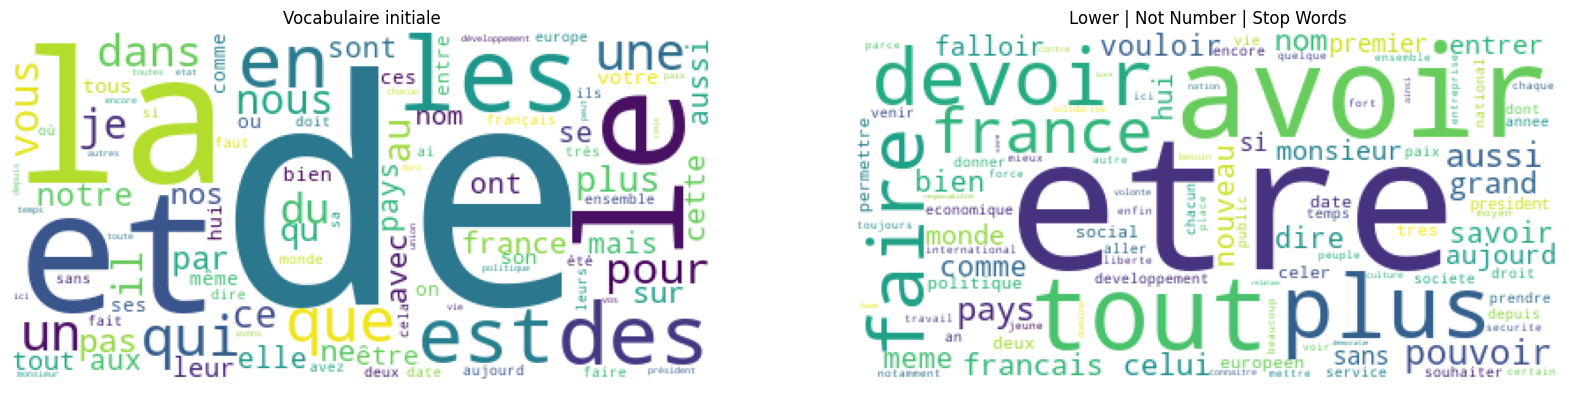

In [17]:
fig, axs = plt.subplots(1, len(strats)+1, figsize=(20, 5))

wordcloud = get_wordcloud(None, count_vec=True)
axs[0].imshow(wordcloud)
axs[0].set_title('Vocabulaire initiale')
axs[0].axis("off")

for i, X in enumerate(strats):
    wordcloud = get_wordcloud(X, count_vec=True)
    axs[i+1].imshow(wordcloud)
    axs[i+1].set_title(X["name"])
    axs[i+1].axis("off")

plt.show()

Quels sont les 100 mots dont la fréquence documentaire est la plus grande? [word cloud]

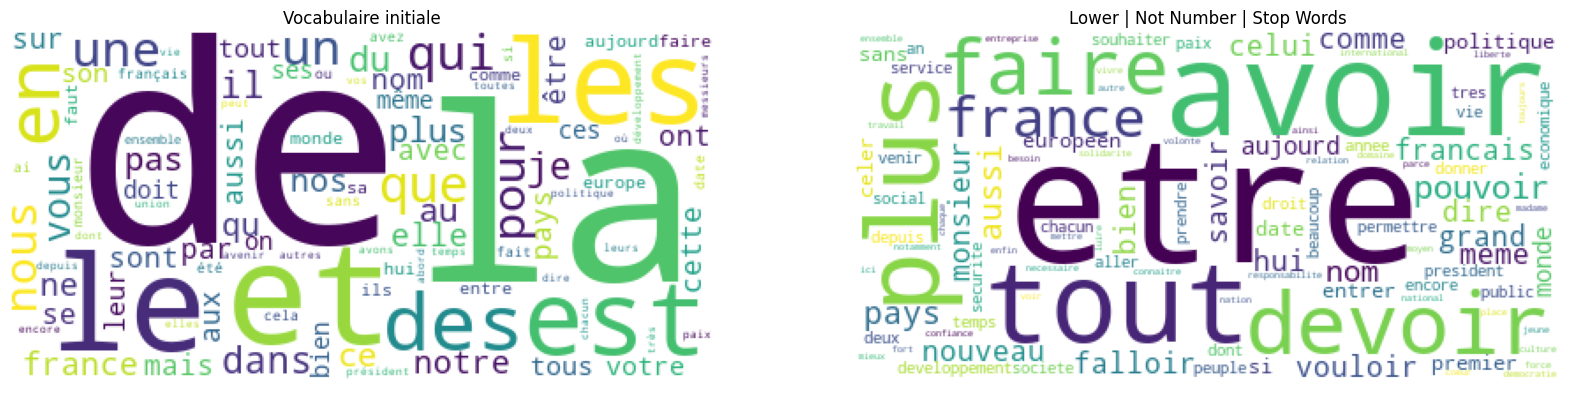

In [18]:
fig, axs = plt.subplots(1, len(strats)+1, figsize=(20, 5))

wordcloud = get_wordcloud(None, count_vec=False)
axs[0].imshow(wordcloud)
axs[0].set_title('Vocabulaire initiale')
axs[0].axis("off")

for i, X in enumerate(strats):
    wordcloud = get_wordcloud(X, count_vec=False)
    axs[i+1].imshow(wordcloud)
    axs[i+1].set_title(X["name"])
    axs[i+1].axis("off")

plt.show()

Quels sont les 100 mots les plus discriminants au sens de odds ratio? [word cloud]

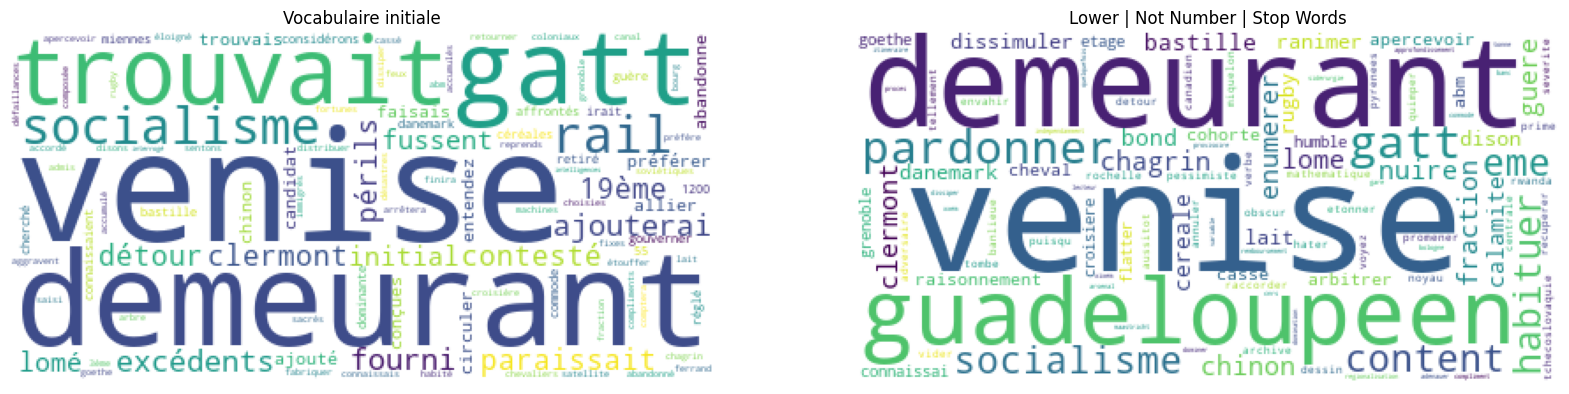

In [19]:
fig, axs = plt.subplots(1, len(strats)+1, figsize=(20, 5))

wordcloud = get_wordcloud(None, count_vec=True, odd_ratio=True)
axs[0].imshow(wordcloud)
axs[0].set_title('Vocabulaire initiale')
axs[0].axis("off")

for i, X in enumerate(strats):
    wordcloud = get_wordcloud(X, count_vec=True, odd_ratio=True)
    axs[i+1].imshow(wordcloud)
    axs[i+1].set_title(X["name"])
    axs[i+1].axis("off")

plt.show()

Quelle est la distribution d'apparition des mots (Zipf)

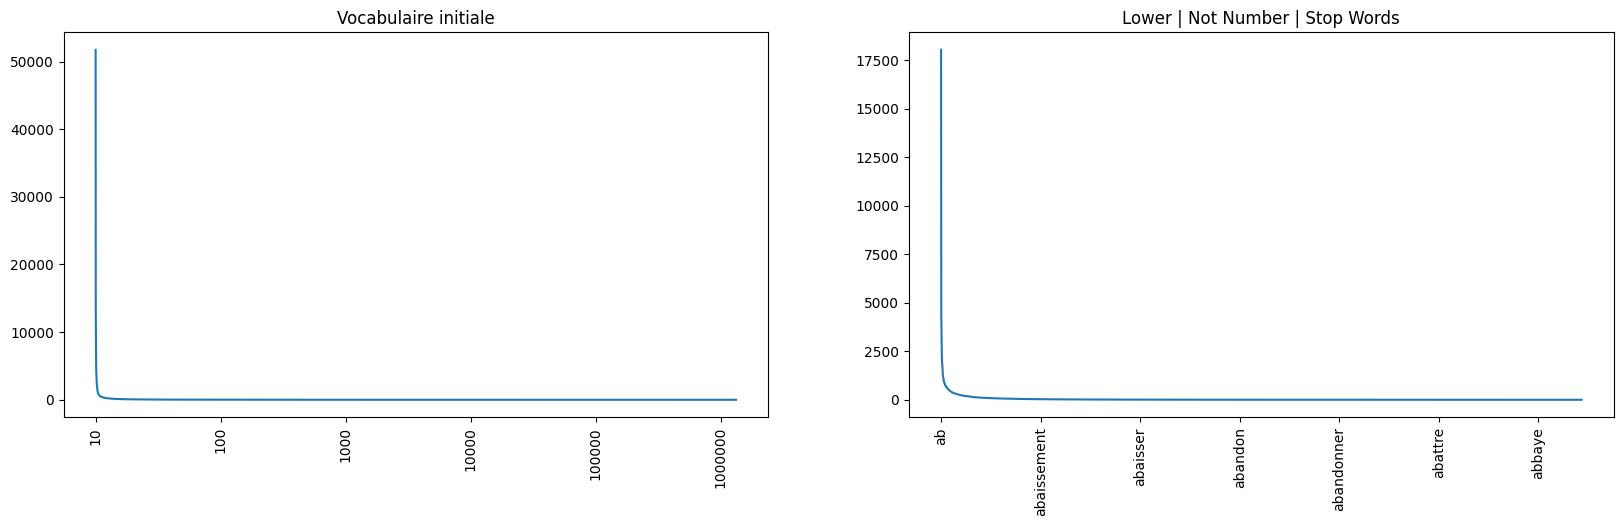

In [20]:
fig, axs = plt.subplots(1, len(strats)+1, figsize=(20, 5))

vectors, vectorizer = fit(None, count_vec=True)
counts = np.array(vectors.sum(axis=0))[0]
index = counts.argsort()[::-1]
axs[0].plot(counts[index])
axs[0].set_title('Vocabulaire initiale')
axs[0].set_xticklabels(vectorizer.get_feature_names_out(), rotation=90)

for i, X in enumerate(strats):
    vectors, vectorizer = fit(X, count_vec=True)
    counts = np.array(vectors.sum(axis=0))[0]
    index = counts.argsort()[::-1]
    axs[i+1].plot(counts[index])
    axs[i+1].set_title(X["name"])
    axs[i+1].set_xticklabels(vectorizer.get_feature_names_out(), rotation=90)

plt.show()

Quels sont les 100 bigrammes/trigrammes les plus fréquents?

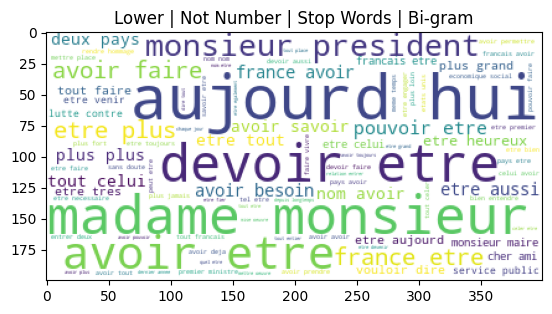

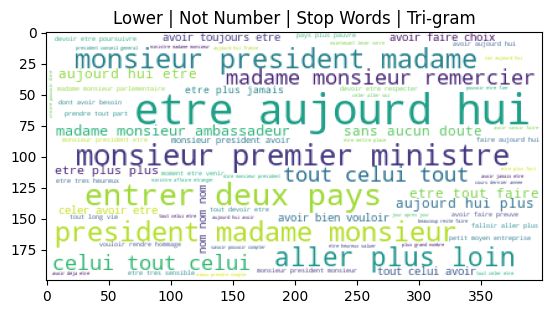

In [21]:
X_bi = {
        "name":"Lower | Not Number | Stop Words | Bi-gram",
        "ToLower": True,
        "DeleteNumbers": True,
        "stopwords": STOP_WORDS,
        "ngram_range": (2, 2),
        "lemmatized": True,

      }

X_tri = {
        "name":"Lower | Not Number | Stop Words | Tri-gram",
        "ToLower": True,
        "DeleteNumbers": True,
        "stopwords": STOP_WORDS,
        "ngram_range": (3, 3),
        "lemmatized": True,
      }

for X in [X_bi, X_tri]:
  wordcloud = get_wordcloud(X, count_vec=False)
  plt.imshow(wordcloud)
  plt.title(X["name"])
  plt.show()

- **Variantes de BoW**
    - TF-IDF
    - Réduire la taille du vocabulaire (min_df, max_df, max_features)
    - BoW binaire
    - Bi-grams, tri-grams
    - **Quelles performances attendrent? Quels sont les avantages et les inconvénients des ces variantes?**

In [22]:
strats.append({
        "name":"Lower | Not Number | Stop Words | TF",
        "ToLower": True,
        "DeleteNumbers": True,
        "stopwords": STOP_WORDS,
        "use_idf": False,
        "lemmatized": True,
      })
strats.append({
        "name":"Lower | Not Number | Stop Words | min_max_df",
        "ToLower": True,
        "DeleteNumbers": True,
        "stopwords": STOP_WORDS,
        "min_df" : 6,
        "max_df" : 0.93,
        "lemmatized": True,
      })

strats.append({
        "name":"Lower | Not Number | Stop Words | max_features",
        "ToLower": True,
        "DeleteNumbers": True,
        "stopwords": STOP_WORDS,
        "max_features" : 10000,
        "lemmatized": True,
      })

strats.append({
        "name":"Lower | Not Number | Stop Words | Binary",
        "ToLower": True,
        "DeleteNumbers": True,
        "stopwords": STOP_WORDS,
        "binary" : True,
        "lemmatized": True,
      })

strats.append(X_bi)

strats.append(X_tri)


In [23]:
for X in strats:
    vectors, vectorizer = fit(X, count_vec=False)
    X["base"] = vectors
    X["vectorizer"] = vectorizer

# C) Modèles de Machine Learning

In [76]:
def eval_model(labels, y_hat):
    scores = {}
    scores["f1_score"]= f1_score(labels, y_hat)
    scores["accuracy"] = accuracy_score(labels, y_hat)
    scores["auc_roc"] = roc_auc_score(labels, y_hat)
    return scores

In [77]:
if "Xtest_lem" not in globals():
    Xtest_lem = lemmatize_data(Xtest)

Xtest_lem

array(['ce exigence éthique qui nous rassembler et qui justifier à notre oeil que le , dans le respect de son alliance , se donne désormais le moyen de poursuivre son propre politique étranger et de sécurité .',
       'le premier concerner le sujet global que le 8 pays de sommet de Lyon être conduire à traiter ensemble chaque année et de façon de plus en plus approfondie .',
       'comme le autre puissance , ou le principal puissance économique , il y avoir donc un part de responsabilité , un large part de responsabilité dans le préservation un échange , dans le maintien un équilibre mondial , dans le respect un intérêt légitime de chacun , on ne pouvoir pas se de ce problème , on ne pouvoir pas considérer que sur ce planète rétréci , dont on pouvoir faire le tour si vite , on ne pouvoir pas considérer que le problème , parce que être encore pour notre esprit étriquer un peu trop loin de nous , ne être pas de notre domaine , au moins intellectuel , et généralement politique .',
     

In [78]:
classes, counts = np.unique(ytest, return_counts=True)
N = counts[np.argmin(counts)]

def balance_classes(X, y, N):
    pos_indices = np.where(y == 1)[0]
    neg_indices = np.where(y == -1)[0]
    pos_sampled = np.random.choice(pos_indices, N, replace=False)
    neg_sampled = np.random.choice(neg_indices, N, replace=False)
    sampled_indices = np.concatenate([pos_sampled, neg_sampled])
    np.random.shuffle(sampled_indices)
    X_balanced = X[sampled_indices]
    y_balanced = y[sampled_indices]
    return X_balanced, y_balanced

X_balance, Y_balance = balance_classes(Xtest, ytest, N)

In [67]:
def reglog_optimizer(X, max_iter=1000):
    reglog = LogisticRegression(max_iter=max_iter, class_weight='balanced')
    params = {'C': [0.01, 0.1, 0.5, 1, 2], 'penalty': ['l2', None]}
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

    reglog = GridSearchCV(reglog, params, cv=cv, n_jobs=-1, scoring='f1_macro')
    reglog.fit(X["base"], ytrain)

    return reglog

In [79]:
restart = True
for X in tqdm(strats):
    
    if restart:
        reglog = reglog_optimizer(X)
        X["reglog"] = reglog

 71%|███████▏  | 5/7 [03:51<01:32, 46.28s/it]


KeyboardInterrupt: 

In [81]:
for X in tqdm(strats):
    Xtest_tran = X["vectorizer"].transform(Xtest_lem)
    y_hat = X["reglog"].predict(Xtest_tran)
    X["scores_reglog"] = eval_model(ytest, y_hat)

100%|██████████| 7/7 [00:02<00:00,  2.56it/s]


In [82]:
for X in strats:
    print(X["scores_reglog"])

{'f1_score': 0.8881178788657587, 'accuracy': 0.8180298174724815, 'auc_roc': 0.781074723742465}
{'f1_score': 0.880418341328493, 'accuracy': 0.8072314337466908, 'auc_roc': 0.7807302689279338}
{'f1_score': 0.8801173374746559, 'accuracy': 0.8063954298453393, 'auc_roc': 0.7741545342405306}
{'f1_score': 0.8876890774306896, 'accuracy': 0.8174028145464679, 'auc_roc': 0.7807139444592132}
{'f1_score': 0.8899247348614437, 'accuracy': 0.8206771631600948, 'auc_roc': 0.7825980140495283}
{'f1_score': 0.913445173839047, 'accuracy': 0.8511913055594259, 'auc_roc': 0.7035437267517508}
{'f1_score': 0.9041835357624831, 'accuracy': 0.831823881844782, 'auc_roc': 0.6027850566580539}


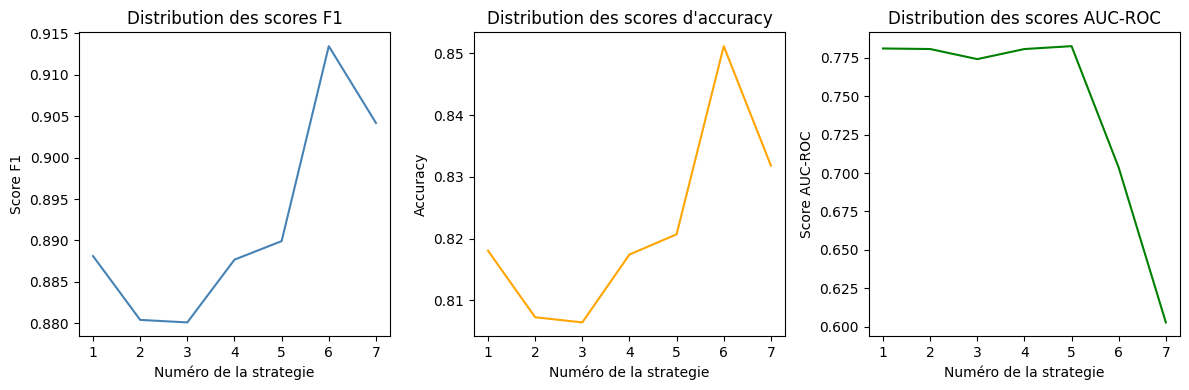

In [104]:

f1_scores = []
accuracy_scores = []
roc_auc_scores = []

for X in strats:
    f1_scores.append(X["scores_reglog"]['f1_score'])
    accuracy_scores.append(X["scores_reglog"]['accuracy'])
    roc_auc_scores.append(X["scores_reglog"]['auc_roc'])

# Création du subplot horizontal
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Lineplot pour les scores F1
sns.lineplot(x=list(range(1, len(f1_scores)+1)), y=f1_scores, color='steelblue', ax=axs[0])
axs[0].set_xlabel('Numéro de la strategie')
axs[0].set_ylabel('Score F1')
axs[0].set_title('Distribution des scores F1')

# Lineplot pour les scores d'accuracy
sns.lineplot(x=list(range(1, len(accuracy_scores)+1)), y=accuracy_scores, color='orange', ax=axs[1])
axs[1].set_xlabel('Numéro de la strategie')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Distribution des scores d\'accuracy')

# Lineplot pour les scores AUC-ROC
sns.lineplot(x=list(range(1, len(roc_auc_scores)+1)), y=roc_auc_scores, color='green', ax=axs[2])
axs[2].set_xlabel('Numéro de la strategie')
axs[2].set_ylabel('Score AUC-ROC')
axs[2].set_title('Distribution des scores AUC-ROC')

# Ajustement de la disposition des subplots
plt.tight_layout()

# Affichage du plot
plt.show()

In [73]:
for X in tqdm(strats):
    X_bal_trans = X["vectorizer"].transform(X_balance)
    y_hat = X["reglog"].predict(X_bal_trans)
    X["scores_reglog_balanced"] = eval_model(Y_balance, y_hat)

100%|██████████| 7/7 [00:00<00:00,  7.50it/s]


In [74]:
for X in strats:
    print(X["scores_reglog_balanced"])

{'f1_score': 0.7565698478561549, 'accuracy': 0.7192982456140351, 'auc_roc': 0.7192982456140351}
{'f1_score': 0.7566557683325549, 'accuracy': 0.7230196703880915, 'auc_roc': 0.7230196703880915}
{'f1_score': 0.7537190082644629, 'accuracy': 0.7227538543328017, 'auc_roc': 0.7227538543328018}
{'f1_score': 0.7573580533024334, 'accuracy': 0.7216905901116427, 'auc_roc': 0.7216905901116428}
{'f1_score': 0.7600741083835109, 'accuracy': 0.7246145667198298, 'auc_roc': 0.7246145667198298}
{'f1_score': 0.7030446816923684, 'accuracy': 0.6007442849548112, 'auc_roc': 0.6007442849548112}
{'f1_score': 0.6746367482067316, 'accuracy': 0.5297713981924508, 'auc_roc': 0.5297713981924508}


In [ ]:
def rf_optimizer(X, n_estimators=100):
    rf = RandomForestClassifier(n_estimators=n_estimators, class_weight='balanced')
    params = {'max_depth': [5, 7, 12], 'min_samples_split': [5, 10, 20]}
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

    rf = GridSearchCV(rf, params, cv=cv, n_jobs=-1, scoring='f1_macro')
    rf.fit(X["base"], ytrain)

    return rf

In [45]:
restart = True
for X in tqdm(strats):
    
    if restart:
        rf = rf_optimizer(X)
        X["rf"] = rf

In [ ]:
for X in tqdm(strats):
    Xtest_tran = X["vectorizer"].transform(Xtest_lem)
    y_hat = X["rf"].predict(Xtest_tran)
    X["scores_rf"] = eval_model(ytest, y_hat)

In [ ]:
for X in strats:
    print(X["scores_rf"])

In [ ]:
for X in tqdm(strats):
    X_bal_trans = X["vectorizer"].transform(X_balance)
    y_hat = X["rf"].predict(X_bal_trans)
    X["scores_rf_balanced"] = eval_model(Y_balance, y_hat)

In [ ]:
for X in strats:
    print(X["scores_rf_balanced"])